In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.stattools import adfuller, kpss

In [3]:
# Load dataset
data = pd.read_csv('dataset.csv')

In [4]:
# Inspect data
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             2106 non-null   object 
 1   demand           2106 non-null   float64
 2   RRP              2106 non-null   float64
 3   demand_pos_RRP   2106 non-null   float64
 4   RRP_positive     2106 non-null   float64
 5   demand_neg_RRP   2106 non-null   float64
 6   RRP_negative     2106 non-null   float64
 7   frac_at_neg_RRP  2106 non-null   float64
 8   min_temperature  2106 non-null   float64
 9   max_temperature  2106 non-null   float64
 10  solar_exposure   2105 non-null   float64
 11  rainfall         2103 non-null   float64
 12  school_day       2106 non-null   object 
 13  holiday          2106 non-null   object 
dtypes: float64(11), object(3)
memory usage: 230.5+ KB
None
         date      demand        RRP  demand_pos_RRP  RRP_positive  \
0  2015-01-01   99635.030  

In [5]:
# Preserve 'date' column for Prophet
if 'date' in data.columns:
    date_column = data['date']

In [6]:
# Handling missing values
missing_before = data.isna().sum().sum()
imputer = SimpleImputer(strategy='median')
data[data.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(data.select_dtypes(include=[np.number]))
missing_after = data.isna().sum().sum()
print(f'Missing values before: {missing_before}, after: {missing_after}')

Missing values before: 4, after: 0


In [7]:
# Converting school days and holidays to binary (0, 1)
if 'school_day' in data.columns and 'holiday' in data.columns:
    data['is_school_day'] = data['school_day'].apply(lambda x: 1 if x == 'Y' else 0)
    data['is_holiday'] = data['holiday'].apply(lambda x: 1 if x == 'Y' else 0)
    data.drop(columns=['school_day', 'holiday'], inplace=True)

In [8]:
# Identify and one-hot encode categorical features
cat_features = data.select_dtypes(include=['object']).columns.tolist()
if 'date' in cat_features:
    cat_features.remove('date')  # Ensure 'date' is not one-hot encoded

if cat_features:
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(data[cat_features])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_features))
    data = pd.concat([data, encoded_df], axis=1)
    data.drop(columns=cat_features, inplace=True)

In [9]:
# Reattach 'date' column
data['date'] = date_column

In [10]:
# Outlier detection and removal
iso_forest = IsolationForest(contamination=0.01)
outliers = iso_forest.fit_predict(data.select_dtypes(include=[np.number]))
data = data[outliers == 1]

In [11]:
# Final cleaned dataset
cleaned_data = data.copy()
print(f'Final cleaned dataset shape: {cleaned_data.shape}')

Final cleaned dataset shape: (2084, 14)


In [12]:
# Prepare data for Prophet
if 'date' in cleaned_data.columns and 'demand' in cleaned_data.columns:
    prophet_data = cleaned_data[['date', 'demand']].rename(columns={'date': 'ds', 'demand': 'y'})
else:
    raise ValueError("Required columns 'date' and 'demand' not found")

In [13]:
# Prophet performance before preprocessing
train_data, test_data = train_test_split(prophet_data, test_size=0.2, random_state=42, shuffle=False)
prophet_model = Prophet(growth='linear', seasonality_mode='additive', changepoint_prior_scale=0.05, weekly_seasonality=True, yearly_seasonality=True)
prophet_model.fit(train_data)
future = prophet_model.make_future_dataframe(periods=365, freq='D')  # One-year forecast
forecast = prophet_model.predict(future)

y_true_before = test_data['y'].values
y_pred_before = forecast['yhat'][-len(test_data):].values
mae_prophet_before = mean_absolute_error(y_true_before, y_pred_before)
rmse_prophet_before = np.sqrt(mean_squared_error(y_true_before, y_pred_before))

10:20:48 - cmdstanpy - INFO - Chain [1] start processing
10:20:49 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Prophet performance after preprocessing
prophet_data_cleaned = prophet_data.dropna()
train_data_cleaned, test_data_cleaned = train_test_split(prophet_data_cleaned, test_size=0.2, random_state=42, shuffle=False)
prophet_model_cleaned = Prophet(growth='linear', seasonality_mode='additive', changepoint_prior_scale=0.05, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_cleaned.fit(train_data_cleaned)
future_cleaned = prophet_model_cleaned.make_future_dataframe(periods=365, freq='D')  # One-year forecast
forecast_cleaned = prophet_model_cleaned.predict(future_cleaned)

y_true_after = test_data_cleaned['y'].values
y_pred_after = forecast_cleaned['yhat'][-len(test_data_cleaned):].values
mae_prophet_after = mean_absolute_error(y_true_after, y_pred_after)
rmse_prophet_after = np.sqrt(mean_squared_error(y_true_after, y_pred_after))

10:21:05 - cmdstanpy - INFO - Chain [1] start processing
10:21:06 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# XGBoost Model
X = cleaned_data.drop(columns=['date', 'demand'])
y = cleaned_data['demand']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

In [16]:
# Performance comparison
print("Performance Comparison")
print(f"Prophet Before Preprocessing - MAE: {mae_prophet_before}, RMSE: {rmse_prophet_before}")
print(f"Prophet After Preprocessing - MAE: {mae_prophet_after}, RMSE: {rmse_prophet_after}")
print(f"XGBoost - MAE: {mae_xgb}, RMSE: {rmse_xgb}")

Performance Comparison
Prophet Before Preprocessing - MAE: 13518.769226807397, RMSE: 16668.023717244854
Prophet After Preprocessing - MAE: 13518.769226807397, RMSE: 16668.023717244854
XGBoost - MAE: 213.93068869904, RMSE: 553.7180474993875


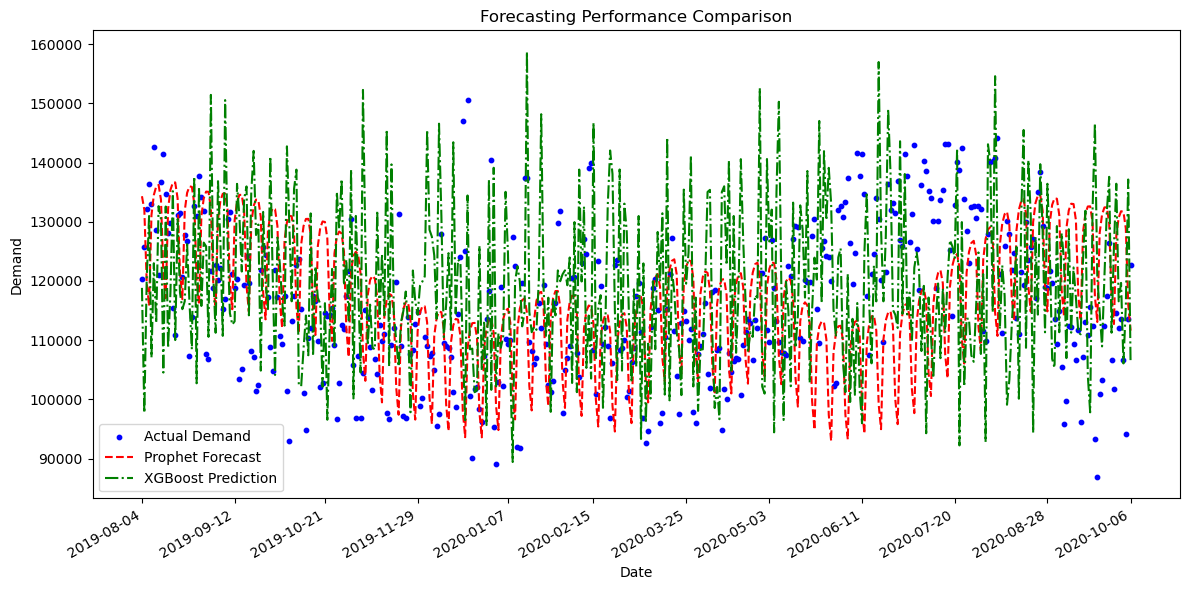

In [28]:
# Improved Visualization
plt.figure(figsize=(12, 6))
plt.scatter(test_data_cleaned['ds'], y_true_after, label='Actual Demand', color='blue', s=10)
plt.plot(test_data_cleaned['ds'], y_pred_after, label='Prophet Forecast', color='red', linestyle='--')
plt.plot(test_data_cleaned['ds'], y_pred_xgb[:len(test_data_cleaned)], label='XGBoost Prediction', color='green', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Forecasting Performance Comparison')
plt.legend()
plt.xticks(pd.date_range(start=test_data_cleaned['ds'].min(), end=test_data_cleaned['ds'].max(), periods=12).strftime('%Y-%m-%d'), rotation=45)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [29]:
# Save cleaned data to CSV
cleaned_data.to_csv('cleaned_dataset.csv', index=False)